<a href="https://colab.research.google.com/github/OJB-Quantum/Quantum-Native-Solvers/blob/main/Colab%20Example%20Notebooks/Dy_Low_Temperature_Magnetization_Prediction_Qiskit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [ ]:
# # Dy Magnetization with Qiskit Aer only (energy-basis global Kraus)
#
# This notebook evolves a Dy giant-spin (J=15/2, d=16) with
# U = exp(-i H Δt / ħ), then applies an energy-basis CPTP channel
# that (i) weakly resets toward a Gibbs state at temperature T and
# (ii) adds multi-level dephasing in the same basis. No qiskit-dynamics.
#
# Requirements:
#   - Qiskit >= 2.1,<3 and qiskit-aer == 0.17.*
#   - NumPy, SciPy, Matplotlib
#
# References for APIs and noise plumbing (Aer 0.17):
#   - Building noise models & QuantumError/Kraus
#   - Applying noise to custom Unitary gates
#   - density_matrix simulation & SaveDensityMatrix

In [ ]:
# --------------------------------------------------------------
#   Install a Qiskit core that matches the GPU‑enabled Aer wheel
# --------------------------------------------------------------

#   Remove any existing Qiskit / Aer installations (CPU‑only)
%pip uninstall -y qiskit-aer qiskit > /dev/null 2>&1

#   Install the Qiskit meta‑package (≥ 1.1.0) and the GPU wheel.
#     The GPU wheel overwrites the regular Aer package and is built
#     for CUDA 12, which is what a Colab L4 runtime provides.
%pip install "qiskit>=1.1.0,<2.0" "qiskit-aer-gpu==0.15.1" numpy scipy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.1/237.1 MB 3.2 MB/s eta 0:00:00


In [ ]:
from qiskit_aer import AerSimulator

# Request the density‑matrix simulator and explicitly ask for the GPU
sim = AerSimulator(method="density_matrix", device="GPU")
print("Available devices :", sim.available_devices())

Available devices : ['GPU']


▶︎ Simulating T = 0.01 K (1/20)
▶︎ Simulating T = 0.01659 K (2/20)
▶︎ Simulating T = 0.02752 K (3/20)
▶︎ Simulating T = 0.04564 K (4/20)
▶︎ Simulating T = 0.07571 K (5/20)
▶︎ Simulating T = 0.1256 K (6/20)
▶︎ Simulating T = 0.2083 K (7/20)
▶︎ Simulating T = 0.3456 K (8/20)
▶︎ Simulating T = 0.5733 K (9/20)
▶︎ Simulating T = 0.9509 K (10/20)
▶︎ Simulating T = 1.577 K (11/20)
▶︎ Simulating T = 2.617 K (12/20)
▶︎ Simulating T = 4.34 K (13/20)
▶︎ Simulating T = 7.2 K (14/20)
▶︎ Simulating T = 11.94 K (15/20)
▶︎ Simulating T = 19.81 K (16/20)
▶︎ Simulating T = 32.86 K (17/20)
▶︎ Simulating T = 54.51 K (18/20)
▶︎ Simulating T = 90.43 K (19/20)
▶︎ Simulating T = 150 K (20/20)


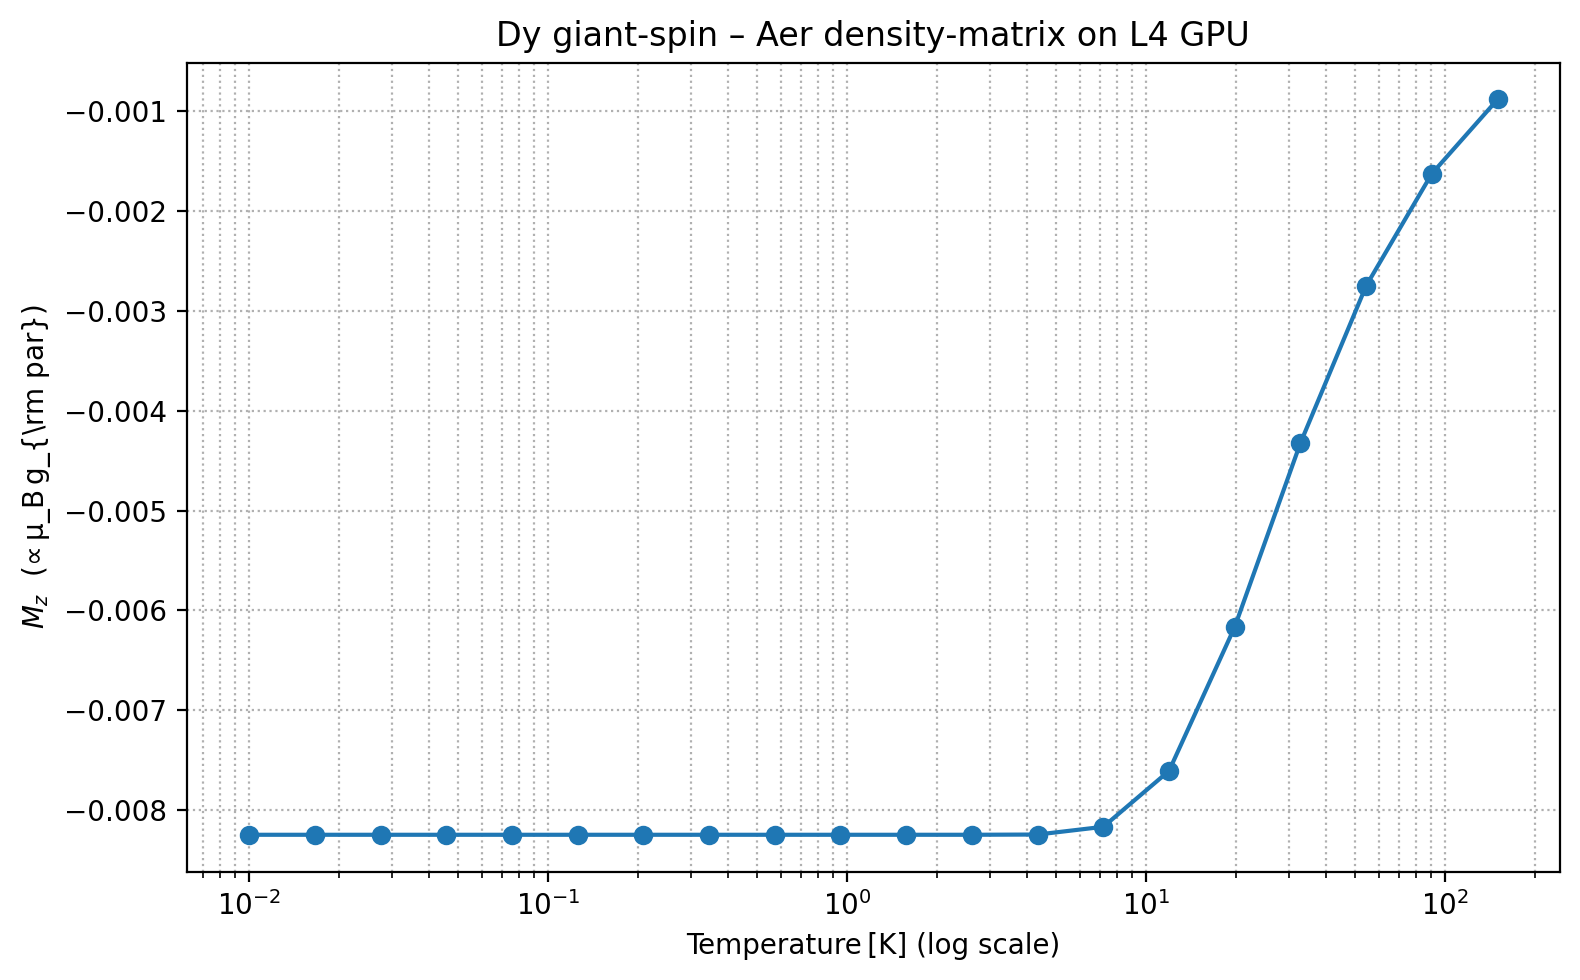


   T [K]        Mz
  0.0100  -8.247957e-03
  0.0166  -8.247957e-03
  0.0275  -8.247957e-03
  0.0456  -8.247957e-03
  0.0757  -8.247957e-03
  0.1256  -8.247957e-03
  0.2083  -8.247957e-03
  0.3456  -8.247957e-03
  0.5733  -8.247957e-03
  0.9509  -8.247957e-03
  1.5774  -8.247957e-03
  2.6166  -8.247950e-03
  4.3404  -8.245550e-03
  7.1999  -8.167997e-03
 11.9432  -7.607960e-03
 19.8114  -6.165939e-03
 32.8631  -4.323446e-03
 54.5133  -2.748670e-03
 90.4268  -1.625281e-03
150.0000  -8.818292e-04


In [ ]:
# --------------------------------------------------------------
# 1 – Physical constants (SI)
# --------------------------------------------------------------
HBAR = 6.582_119_569e-16      # eV·s
MU_B = 5.788_381_806e-5       # eV/T
K_B  = 8.617_333_262_145e-5  # eV/K

# --------------------------------------------------------------
# 2 – User‑controllable parameters (dataclass)
# --------------------------------------------------------------
from dataclasses import dataclass, field
from typing import List, Tuple
import numpy as np

@dataclass
class Params:
    """All knobs that define the Dy giant‑spin model."""
    J: float = 15.0 / 2.0               # Dy³⁺ → d = 2J+1 = 16
    D_eV: float = -1.0e-3
    E_eV: float =  0.02e-3
    g_par: float = 19.0
    g_perp: float = 0.5
    B_T: Tuple[float, float, float] = (0.0, 0.0, 0.2)
    dt_s: float = 2.0e-6
    t_final_s: float = 4.0e-3
    temps_K: List[float] = field(
        default_factory=lambda: list(np.geomspace(1e-2, 150.0, 20))
    )
    gamma0_relax: float = 2.0e8
    raman_n: int = 7
    Ueff_eV: float = 0.020
    gamma_phi0: float = 2.0e7
    kraus_atol: float = 1e-10
    kraus_clamp: float = 1e-9
    kraus_max_terms: int = 0            # 0 → no compression

KNOBS = Params()   # global instance used by helper functions

# --------------------------------------------------------------
# 3 – Spin‑J matrices (|m⟩ basis)
# --------------------------------------------------------------
import math
from typing import Tuple

def spin_matrices(J: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return (Jx, Jy, Jz) for a spin‑J system."""
    m = np.arange(J, -J - 1, -1, dtype=float)
    d = m.size
    Jp = np.zeros((d, d), dtype=complex)
    for i in range(d - 1):
        coeff = math.sqrt((J - m[i]) * (J + m[i] + 1))
        Jp[i, i + 1] = coeff
    Jm = Jp.conj().T
    Jx = 0.5 * (Jp + Jm)
    Jy = -0.5j * (Jp - Jm)
    Jz = np.diag(m)
    return Jx, Jy, Jz

# --------------------------------------------------------------
# 4 – Hamiltonian (eV)
# --------------------------------------------------------------
def dy_hamiltonian(p: Params) -> np.ndarray:
    """Toy Hamiltonian H = D Jz² + E (Jx²‑Jy²) + μB g·B."""
    Jx, Jy, Jz = spin_matrices(p.J)
    h_cf = p.D_eV * (Jz @ Jz) + p.E_eV * (Jx @ Jx - Jy @ Jy)
    gx, gy, gz = p.g_perp, p.g_perp, p.g_par
    Bx, By, Bz = p.B_T
    h_z = MU_B * (gx * Bx * Jx + gy * By * Jy + gz * Bz * Jz)
    return h_cf + h_z

# --------------------------------------------------------------
# 5 – Numerically safe coth
# --------------------------------------------------------------
def _coth_safe(x: float) -> float:
    """Series / asymptotic expansion for coth(x)."""
    if x <= 1e-6:
        return 1.0 / x + x / 3.0 - (x ** 3) / 45.0
    if x >= 20.0:
        return 1.0 + 2.0 * math.exp(-2.0 * x)
    return 1.0 / math.tanh(x)

# --------------------------------------------------------------
# 6 – Relaxation / dephasing rates (1/s) for a given temperature
# --------------------------------------------------------------
def relaxation_and_dephasing(
    h_eV: np.ndarray,
    p: Params,
    T_K: float,
) -> Tuple[float, float]:
    """Return (γ_relax, γ_phi)."""
    evals = np.linalg.eigvalsh(h_eV)
    evals = np.sort(evals)
    w0 = abs(evals[1] - evals[0]) / HBAR if evals.size >= 2 else 1.0e9

    # Direct (one‑phonon) term
    x = (HBAR * w0) / (2.0 * K_B * max(T_K, 1e-12))
    direct = p.gamma0_relax * w0 * _coth_safe(x) / 1e12

    # Raman term (∝ Tⁿ)
    raman = p.gamma0_relax * (max(T_K, 1e-12) ** p.raman_n)

    # Orbach term (∝ exp(‑U_eff/kT))
    orbach = p.gamma0_relax * math.exp(-p.Ueff_eV / (K_B * max(T_K, 1e-12)))

    gamma_relax = float(direct + raman + orbach)
    gamma_phi   = float(p.gamma_phi0 + 0.05 * raman)

    return gamma_relax, gamma_phi

# --------------------------------------------------------------
# 7 – Gibbs probabilities (energy basis)
# --------------------------------------------------------------
def gibbs_probabilities(energies_eV: np.ndarray, T_K: float) -> np.ndarray:
    """Boltzmann weights, normalised, in the energy eigenbasis."""
    if T_K <= 0.0:
        p = np.zeros_like(energies_eV)
        p[0] = 1.0
        return p
    e_shift = energies_eV - np.min(energies_eV)
    beta = 1.0 / (K_B * T_K)
    w = np.exp(-beta * e_shift)
    return w / np.sum(w)

# --------------------------------------------------------------
# 8 – Kraus operators for the CPTP channel
# --------------------------------------------------------------
def kraus_reset_to_gibbs(
    energies: np.ndarray,
    V: np.ndarray,
    T_K: float,
    eps: float,
) -> List[np.ndarray]:
    """(1‑ε) ρ + ε ρ_Gibbs(T) expressed as a Kraus set."""
    d = energies.size
    pi = gibbs_probabilities(energies, T_K)

    K0 = np.sqrt(max(0.0, 1.0 - eps)) * np.eye(d, dtype=complex)
    ops = [K0]

    scale = np.sqrt(max(0.0, eps) / d)          # use np.sqrt (works with np.float64)
    for i in range(d):
        for j in range(d):
            K = np.zeros((d, d), dtype=complex)
            # pi[i] is real; we use np.sqrt to avoid the ComplexWarning
            K[i, j] = scale * np.sqrt(pi[i])
            ops.append(K)

    Vdag = V.conj().T
    return [V @ K @ Vdag for K in ops]


def kraus_multilevel_dephasing(
    energies: np.ndarray,
    V: np.ndarray,
    p_dephase: float,
) -> List[np.ndarray]:
    """(1‑p) ρ + p diag(ρ) in the energy basis, rotated back."""
    d = energies.size
    K0 = np.sqrt(max(0.0, 1.0 - p_dephase)) * np.eye(d, dtype=complex)
    ops = [K0]

    for i in range(d):
        K = np.zeros((d, d), dtype=complex)
        K[i, i] = np.sqrt(max(0.0, p_dephase))
        ops.append(K)

    Vdag = V.conj().T
    return [V @ K @ Vdag for K in ops]


def compose_kraus(
    first: List[np.ndarray],
    second: List[np.ndarray],
) -> List[np.ndarray]:
    """Compose two CPTP maps: apply `second` then `first`."""
    return [K1 @ K2 for K1 in first for K2 in second]


def enforce_cptp(kraus_ops: List[np.ndarray], atol: float = 1e-10) -> List[np.ndarray]:
    """
    Project a Kraus list onto the CPTP set (uniform rescaling + extra
    operator if Σ K†K < I).
    """
    d = kraus_ops[0].shape[0]
    S = np.zeros((d, d), dtype=complex)
    for K in kraus_ops:
        S += K.conj().T @ K
    S = 0.5 * (S + S.conj().T)

    # Uniform scaling if ΣK†K > I
    eigvals, _ = np.linalg.eigh(S)
    lam_max = float(eigvals.max())
    if lam_max > 1.0 + atol:
        scale = 1.0 / math.sqrt(lam_max)
        kraus_ops = [scale * K for K in kraus_ops]
        # Re‑compute S after scaling
        S = np.zeros((d, d), dtype=complex)
        for K in kraus_ops:
            S += K.conj().T @ K
        S = 0.5 * (S + S.conj().T)

    # Add extra Kraus operator if needed
    Delta = np.eye(d, dtype=complex) - S
    Delta = 0.5 * (Delta + Delta.conj().T)
    ev, evc = np.linalg.eigh(Delta)
    ev_clip = np.clip(ev, 0.0, None)
    if float(ev_clip.max()) > atol:
        extra = evc @ np.diag(np.sqrt(ev_clip)) @ evc.conj().T
        kraus_ops.append(extra)

    return kraus_ops


# --------------------------------------------------------------
# 9 – Build the Aer NoiseModel for a *single* temperature
# --------------------------------------------------------------
def build_noise_model(
    h_eV: np.ndarray,
    T_K: float,
    p: Params,
) -> NoiseModel:
    """Return a NoiseModel that applies (dephase ∘ reset) after each unitary."""
    energies, V = np.linalg.eig(h_eV)   # eigenvalues + eigenvectors

    gamma_relax, gamma_phi = relaxation_and_dephasing(h_eV, p, T_K)
    dt = p.dt_s
    eps  = 1.0 - math.exp(-dt * min(gamma_relax, 1e12))
    pphi = 1.0 - math.exp(-dt * min(gamma_phi,   1e12))

    eps  = float(np.clip(eps,  p.kraus_clamp, 1.0 - p.kraus_clamp))
    pphi = float(np.clip(pphi, p.kraus_clamp, 1.0 - p.kraus_clamp))

    K_reset = kraus_reset_to_gibbs(energies, V, T_K, eps)
    K_deph  = kraus_multilevel_dephasing(energies, V, pphi)
    K_total = compose_kraus(K_deph, K_reset)

    K_total = enforce_cptp(K_total, atol=p.kraus_atol)

    # --------------------------------------------------------------
    # The current Aer API requires the list of target qubits.
    # --------------------------------------------------------------
    num_qubits = int(np.log2(h_eV.shape[0]))   # for Dy J=15/2 → 4 qubits
    target_qubits = list(range(num_qubits))

    if p.kraus_max_terms and p.kraus_max_terms > 0:
        from qiskit_aer.utils import approximate_quantum_error
        full_qe = QuantumError(Kraus(K_total))
        approx_qe = approximate_quantum_error(
            full_qe,
            operator="kraus",
            num_terms=min(p.kraus_max_terms, len(K_total)),
        )
        nm = NoiseModel()
        nm.add_quantum_error(approx_qe, ["unitary"], target_qubits)
        return nm

    nm = NoiseModel()
    nm.add_quantum_error(QuantumError(Kraus(K_total)), ["unitary"], target_qubits)
    return nm


# --------------------------------------------------------------
# 10 – Unitary step (U = exp(-i H Δt/ħ))
# --------------------------------------------------------------
def unitary_gate(h_eV: np.ndarray, dt_s: float) -> UnitaryGate:
    """Return a `UnitaryGate` that implements one Trotter step."""
    u = expm(-1j * h_eV * (dt_s / HBAR))
    return UnitaryGate(u)


# --------------------------------------------------------------
# 11 – Observable: longitudinal magnetisation Mz
# --------------------------------------------------------------
def mz_observable(rho: np.ndarray, p: Params) -> float:
    """Mz = μB g_par Tr(ρ Jz) in the computational basis."""
    _, _, Jz = spin_matrices(p.J)
    return MU_B * p.g_par * float(np.real(np.trace(rho @ Jz)))


# --------------------------------------------------------------
# 12 – Propagation for a single temperature (GPU‑accelerated)
# --------------------------------------------------------------
def simulate_mz_for_temperature(T_K: float, p: Params) -> float:
    """
    Run the full density‑matrix evolution from t = 0 to `p.t_final_s`
    with the CPTP channel after each unitary step.  Returns the final
    longitudinal magnetisation.
    """
    # a) Hamiltonian, unitary, noise model
    h = dy_hamiltonian(p)
    u_gate = unitary_gate(h, p.dt_s)
    noise = build_noise_model(h, T_K, p)

    # b) Circuit (apply the same unitary N times)
    n_steps = int(math.ceil(p.t_final_s / p.dt_s))
    qc = QuantumCircuit(4, name=f"Dy_T_{T_K:.3g}K")
    for _ in range(n_steps):
        qc.append(u_gate, qc.qubits)

    # Save the final density matrix
    qc.save_density_matrix()

    # c) GPU‑enabled Aer backend
    simulator = AerSimulator(method="density_matrix", device="GPU")

    # No optimisation – we want the exact circuit (the channel is already
    # attached after every Unitary gate).
    compiled = transpile(qc, backend=simulator, optimization_level=0)

    # d) Execute
    result = simulator.run(compiled, noise_model=noise, shots=1).result()
    rho = np.array(result.data(compiled)["density_matrix"], dtype=complex)

    # e) Observable
    return mz_observable(rho, p)


# --------------------------------------------------------------
# 13 – Sweep over the temperature grid and plot
# --------------------------------------------------------------
import matplotlib.pyplot as plt
from typing import Tuple

def sweep_and_plot(p: Params) -> Tuple[np.ndarray, np.ndarray]:
    """
    Run the simulation for every temperature in `p.temps_K`,
    plot Mz(T), and return the raw arrays.
    """
    temps = np.array(p.temps_K, dtype=float)
    magnetisations = np.empty_like(temps)

    for i, T in enumerate(temps):
        print(f"▶︎ Simulating T = {T:.4g} K ({i+1}/{len(temps)})")
        magnetisations[i] = simulate_mz_for_temperature(T, p)

    # Plot ---------------------------------------------------------
    plt.rcParams["figure.dpi"] = 200
    plt.figure(figsize=(8, 5))
    plt.plot(temps, magnetisations, marker="o", linewidth=1.5)
    plt.xscale("log")
    plt.xlabel("Temperature [K] (log scale)")
    plt.ylabel(r"$M_z$  (∝ μ_B g_{\rm par})")
    plt.title("Dy giant‑spin – Aer density‑matrix on L4 GPU")
    plt.grid(True, which="both", ls=":")
    plt.tight_layout()
    plt.show()

    # Table --------------------------------------------------------
    print("\n   T [K]        Mz")
    for T, M in zip(temps, magnetisations):
        print(f"{T:8.4f}  {M: .6e}")

    return temps, magnetisations


# --------------------------------------------------------------
# 14 – Entry point (runs when the cell is executed)
# --------------------------------------------------------------
if __name__ == "__main__":
    # Example: you can increase the resolution of the temperature grid
    # by uncommenting the line below:
    # KNOBS = Params(temps_K=list(np.geomspace(1e-2, 150, 40))
    sweep_and_plot(KNOBS)
